In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.etoile_achat import graphe_etoile_achat

DATA_PATH = "../donnees/ecommerce/"

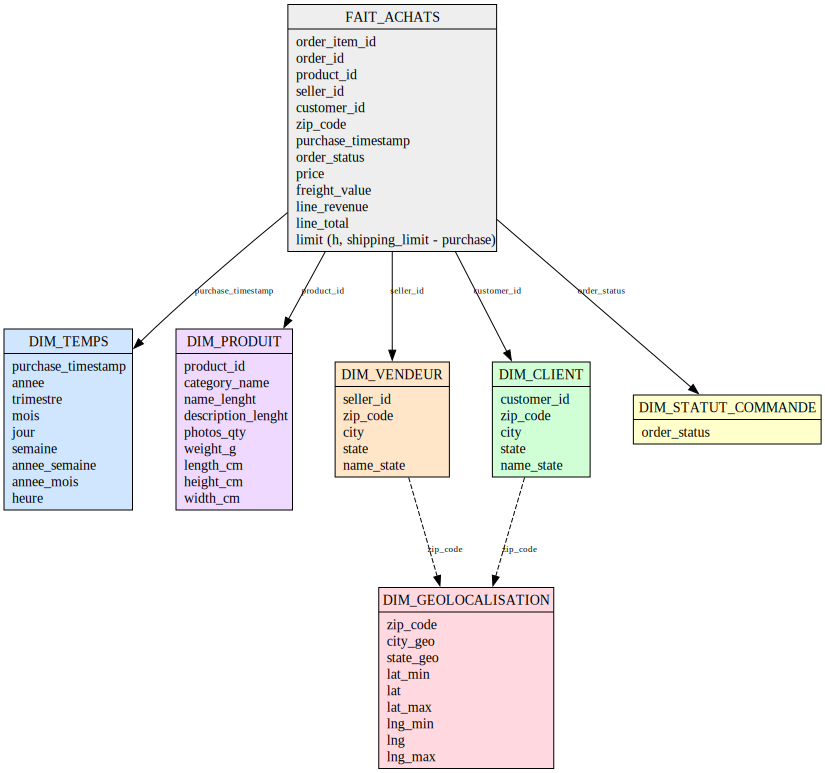

In [7]:
dot_achats = graphe_etoile_achat()
dot_achats

In [8]:
# 1) Lecture des tables de base
orders    = pd.read_parquet(DATA_PATH + "orders.parquet")
items     = pd.read_parquet(DATA_PATH + "items.parquet")
customers = pd.read_parquet(DATA_PATH + "customers.parquet")
sellers   = pd.read_parquet(DATA_PATH + "sellers.parquet")
products  = pd.read_parquet(DATA_PATH + "products.parquet")
geo       = pd.read_parquet(DATA_PATH + "geolocation.parquet")

print("Shapes brutes :")
print("orders   :", orders.shape)
print("items    :", items.shape)
print("customers:", customers.shape)
print("sellers  :", sellers.shape)
print("products :", products.shape)
print("geo      :", geo.shape)


# 2) Préparation de la partie "lignes d'achat" (items)
items_fact_cols = [
    "order_id",
    "order_item_id",
    "product_id",
    "seller_id",
    "price",
    "freight_value",
    "shipping_limit",   # datetime
]
items_fact = items[items_fact_cols].copy()


# 3) Préparation des infos commande (clé client, statut, timestamp)
# On gère le cas 'order_status' ou 'status'
status_col = None
if "order_status" in orders.columns:
    status_col = "order_status"
elif "status" in orders.columns:
    status_col = "status"

orders_fact_cols = ["order_id", "customer_id", "purchase_timestamp"]
if status_col is not None:
    orders_fact_cols.append(status_col)

orders_fact = orders[orders_fact_cols].copy()

# Si la colonne s'appelle 'status', on la renomme en 'order_status'
if "status" in orders_fact.columns and "order_status" not in orders_fact.columns:
    orders_fact = orders_fact.rename(columns={"status": "order_status"})


# 4) Préparation des infos client (zip_code pour la géolocalisation)
cust_fact = customers[["customer_id", "zip_code"]].copy()


# 5) Construction de la table de faits F_ACHATS
F_ACHATS = (
    items_fact
    .merge(orders_fact, on="order_id", how="left")
    .merge(cust_fact,   on="customer_id", how="left")
)

# 5.a) Calcul des métriques de ligne
F_ACHATS["line_revenue"] = F_ACHATS["price"]
F_ACHATS["line_total"]   = F_ACHATS["price"] + F_ACHATS["freight_value"]

# 5.b) Recalcule propre de la durée "limit" (h) = shipping_limit - purchase_timestamp
delta_limit = F_ACHATS["shipping_limit"] - F_ACHATS["purchase_timestamp"]
F_ACHATS["limit"] = delta_limit.dt.total_seconds() / 3600.0

# On enlève shipping_limit si tu veux coller au schéma de F_ACHATS
F_ACHATS = F_ACHATS.drop(columns=["shipping_limit"])


# 6) Réorganisation des colonnes suivant le schéma de l'étoile 2
cols_schema = [
    "order_item_id",
    "order_id",
    "product_id",
    "seller_id",
    "customer_id",
    "zip_code",
    "purchase_timestamp",
    "order_status",     # maintenant présent même si la colonne d'origine s'appelait 'status'
    "price",
    "freight_value",
    "line_revenue",
    "line_total",
    "limit",            # (h) shipping_limit - purchase_timestamp
]

final_cols = [c for c in cols_schema if c in F_ACHATS.columns]
F_ACHATS = F_ACHATS[final_cols]


# 7) Contrôle rapide du résultat
print("F_ACHATS shape :", F_ACHATS.shape)
print("Colonnes (", len(F_ACHATS.columns), "):")
print(list(F_ACHATS.columns))

display(F_ACHATS.head(5))


# 8) Sauvegarde
OUTPUT_PATH = "f_achats.parquet"  # adapte si besoin
F_ACHATS.to_parquet(OUTPUT_PATH, index=False)
print(f"F_ACHATS sauvegardé dans : {OUTPUT_PATH}")


Shapes brutes :
orders   : (99441, 23)
items    : (112650, 8)
customers: (99441, 6)
sellers  : (3095, 5)
products : (32951, 9)
geo      : (19015, 9)
F_ACHATS shape : (112650, 13)
Colonnes ( 13 ):
['order_item_id', 'order_id', 'product_id', 'seller_id', 'customer_id', 'zip_code', 'purchase_timestamp', 'order_status', 'price', 'freight_value', 'line_revenue', 'line_total', 'limit']


,order_item_id,order_id,product_id,seller_id,customer_id,zip_code,purchase_timestamp,order_status,price,freight_value,line_revenue,line_total,limit
0,1,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,3ce436f183e68e07877b285a838db11a,28013,2017-09-13 08:59:02,delivered,58.90,13.29,58.90,72.19,144.775833
1,1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,f6dd3ec061db4e3987629fe6b26e5cce,15775,2017-04-26 10:53:06,delivered,239.90,19.93,239.90,259.83,168.201944
2,1,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,6489ae5e4333f3693df5ad4372dab6d3,35661,2018-01-14 14:33:31,delivered,199.00,17.87,199.00,216.87,96.249722
3,1,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,d4eb9395c8c0431ee92fce09860c5a06,12952,2018-08-08 10:00:35,delivered,12.99,12.79,12.99,25.78,168.161944
4,1,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,58dbd0b2d70206bf40e62cd34e84d795,13226,2017-02-04 13:57:51,delivered,199.90,18.14,199.90,218.04,216.000000


F_ACHATS sauvegardé dans : f_achats.parquet
